# Demo - Exact GP

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [80]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
input_cov = 0.1
X, y, Xtest, ytest = near_square_wave(60, 100, 0.1, input_cov)

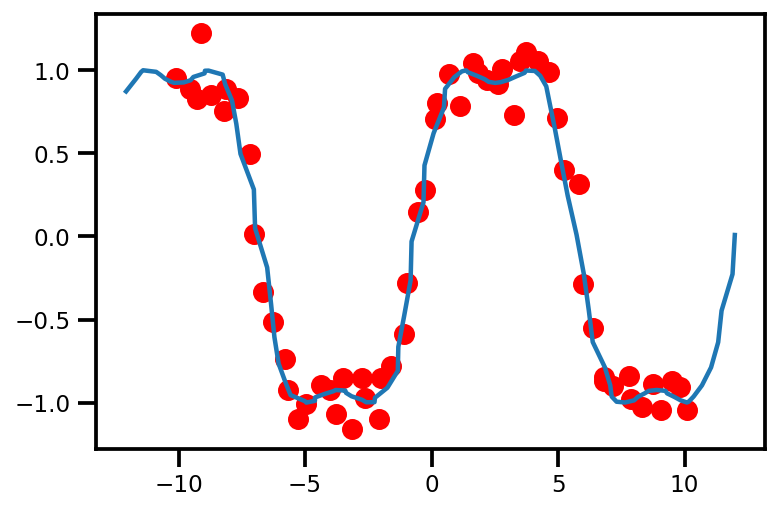

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [30]:
# initialize kernel
kernel = RBF(length_scale=0.01, variance=1.0)

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean()

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RBF).variance [1.]
(ExactGP).kernel(RBF).length_scale [0.01]
(ExactGP).noise [0.1]


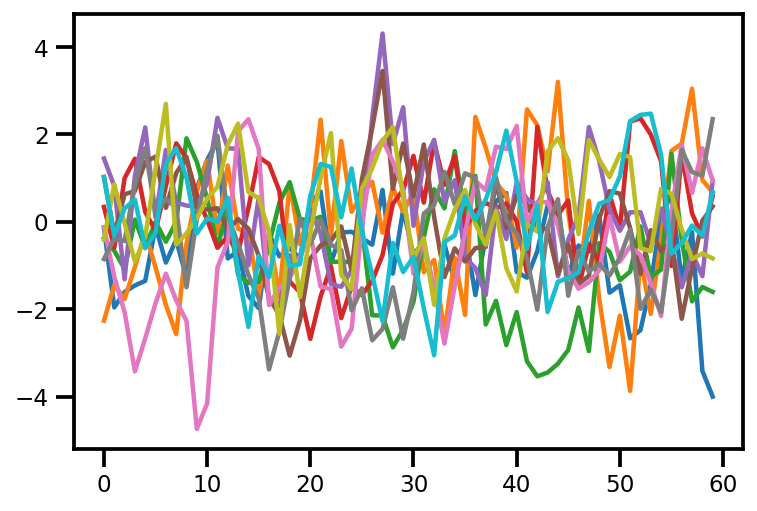

In [31]:
# generate random samples
dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [32]:
loss_f = jax.partial(negative_log_likelihood, gp_model)
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=loss_f,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:02<00:00, 349.42it/s]


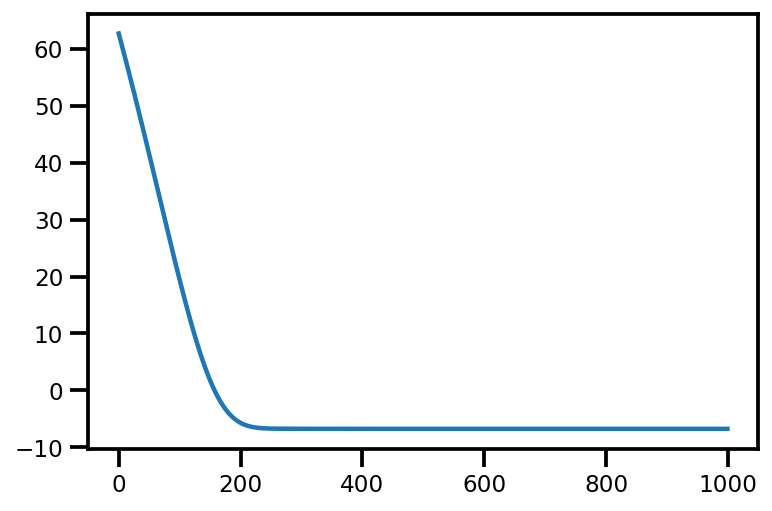

In [33]:
plt.plot(losses)

In [34]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RBF).variance [0.04933923] [0.71812105] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RBF).length_scale [1.6346911] [1.8128479] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-1.9587426] [0.13193631] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [35]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

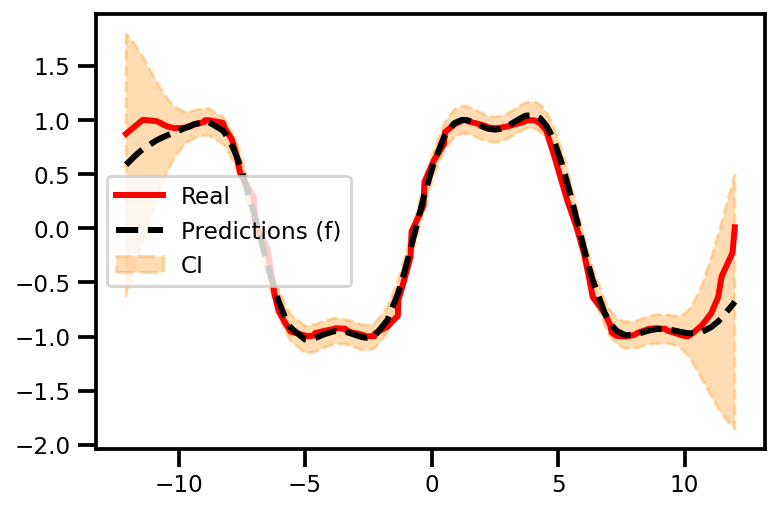

In [36]:
# plot
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [37]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

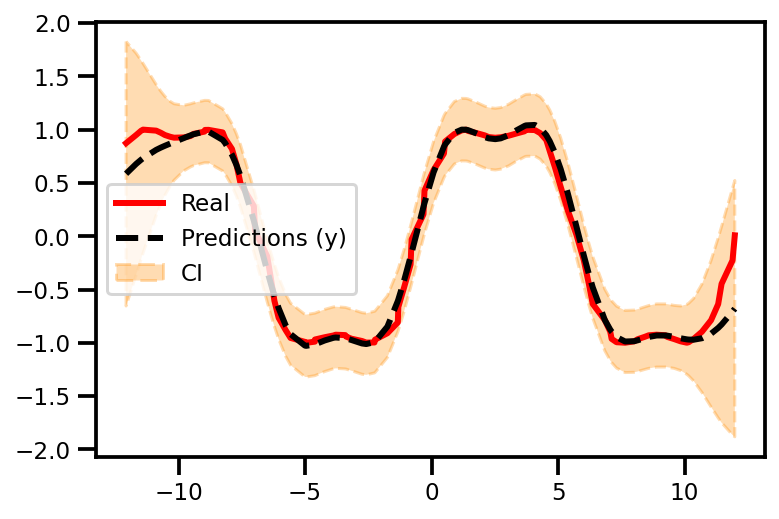

In [38]:
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Taylor Expansion

In [362]:
from jaxkern.gp.predictive import predictive_mean, predictive_variance
from jaxkern.gp.uncertain import TaylorFirstOrder, TaylorSecondOrder

In [375]:
# create functions
f = jax.partial(predictive_mean, model)
df = jax.grad(f)

# initialize linearization transformation
lin_transform = TaylorFirstOrder(model)

In [376]:
Xcov = np.tile(np.diag(np.array([0.3])), (Xtest.shape[0], 1, 1))
mu_o1, var_o1 = lin_transform.forward(Xtest, Xcov)
mu_o1.shape, var_o1.shape

((100,), (100,))

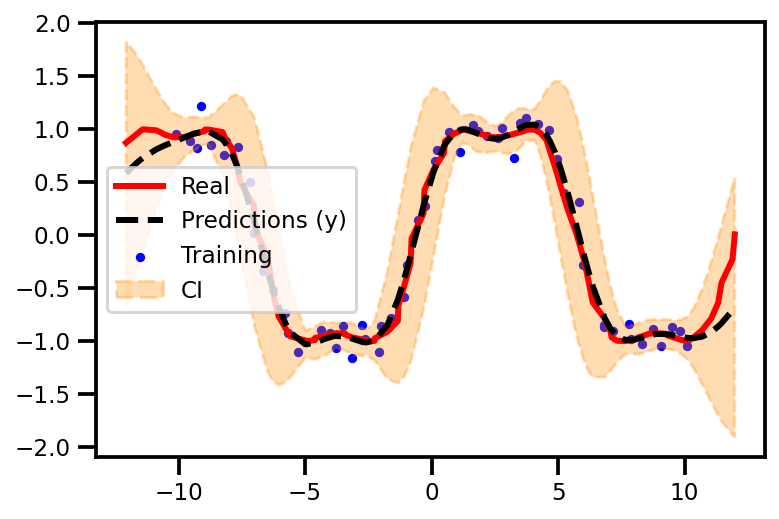

In [377]:
lb, ub = confidence_intervals(mu_o1, var_o1, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [378]:
mu_o1, var_o1 = lin_transform.forward_noise(Xtest, Xcov)
mu_o1.shape, var_o1.shape

((100,), (100,))

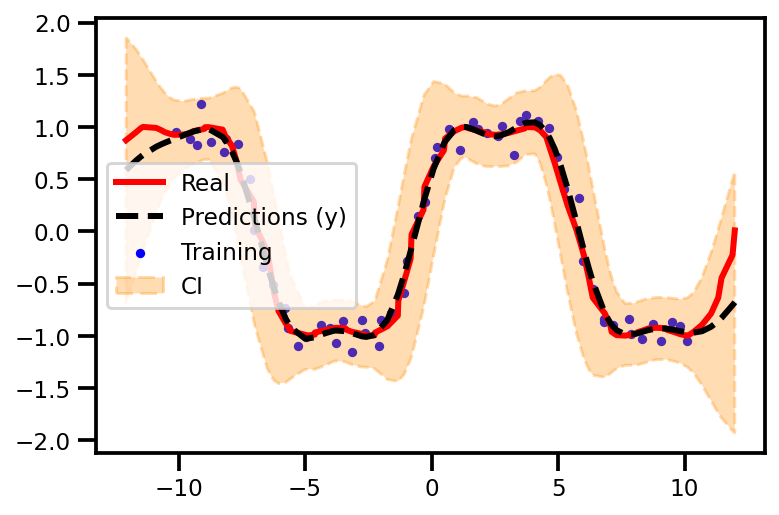

In [379]:
lb, ub = confidence_intervals(mu_o1, var_o1, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

### 2nd Order

In [380]:
# initialize linearization transformation
lin_transform = TaylorSecondOrder(model)

lin_transform

In [381]:
mu_o2, var_o2 = lin_transform.forward(Xtest, Xcov)
mu_o2.shape, var_o2.shape

((100,), (100,))

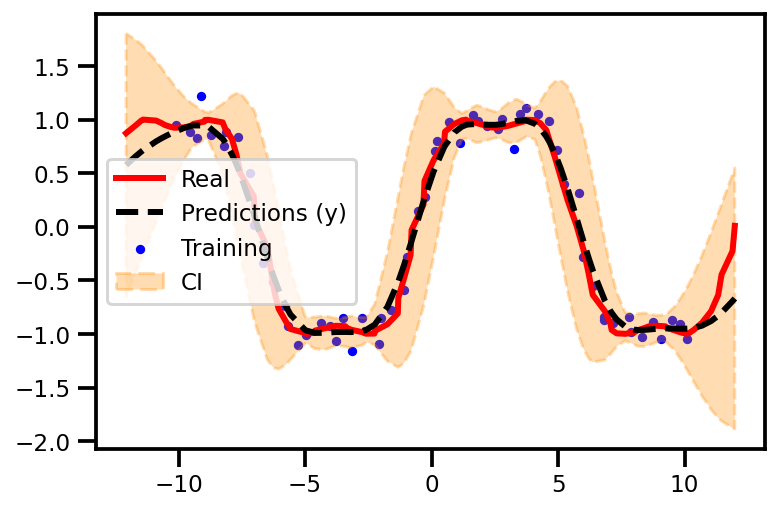

In [382]:
lb, ub = confidence_intervals(mu_o2, var_o2, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o2, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [383]:
Xcov = np.tile(np.diag(np.array([0.1])), (Xtest.shape[0], 1, 1))
mu_o2, var_o2 = lin_transform.forward_noise(Xtest, Xcov)
mu_o2.shape, var_o2.shape

((100,), (100,))

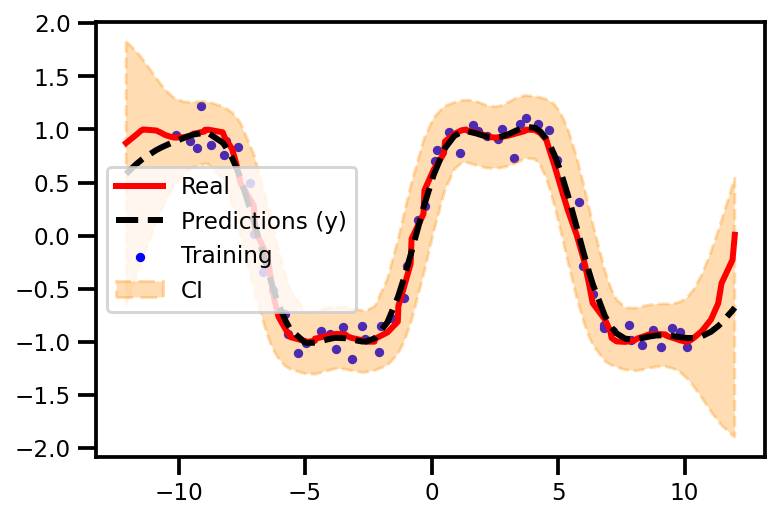

In [384]:
lb, ub = confidence_intervals(mu_o2, var_o2, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o2, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

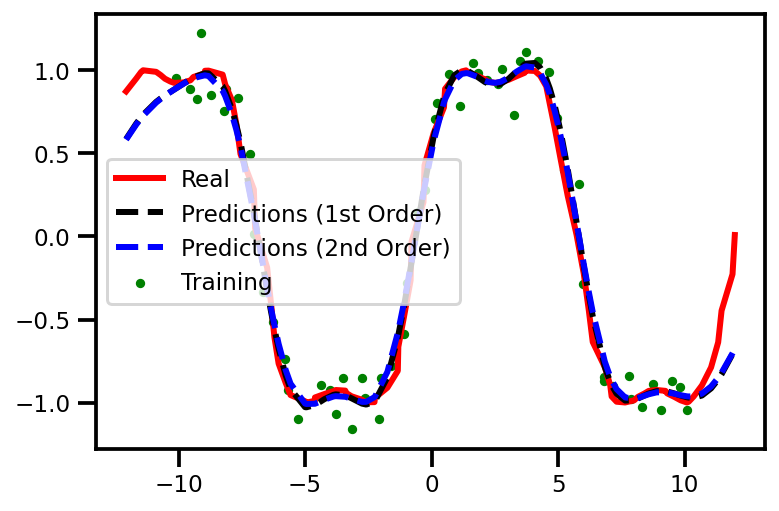

In [385]:
plt.scatter(X, y, label='Training', color='green', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="--", label='Predictions (1st Order)', color='black', linewidth=3)
plt.plot(Xtest, mu_o2, linestyle="--", label='Predictions (2nd Order)', color='blue', linewidth=3)
plt.legend()

In [388]:
X_ = np.linspace(-10, 10, 100_000)
Xcov_ = np.tile(np.diag(np.array([0.3])), (X_.shape[0], 1, 1))

_ = lin_transform.forward(X_, Xcov_)
# %timeit lin_transform.forward(X_, Xcov_)

### 2nd Order

### Gradients

In [389]:
from jaxkern.gp.uncertain import taylor_first_order, taylor_second_order

In [390]:
Xcov = np.tile(np.diag(np.array([0.3])), (Xtest.shape[0], 1, 1))
Xcov.shape

(100, 1, 1)

In [391]:
f = jax.partial(predictive_mean, model)
vf = jax.partial(predictive_variance, model)
df = jax.grad(f)
dvf = jax.grad(vf)
df2 = jax.hessian(f)
dvf2 = jax.hessian(vf)

In [392]:
mu_ = f(Xtest[0])
dmu_ = df(Xtest[0])
d2mu_ = df2(Xtest[0])

var_ = vf(Xtest[0])
dvar_ = dvf(Xtest[0])
d2var_ = dvf2(Xtest[0])

mu_.shape, dmu_.shape, d2mu_.shape, var_.shape, dvar_.shape, d2var_.shape,  

((), (1,), (1, 1), (), (1,), (1, 1))

In [394]:
mu_ = jax.vmap(f)(Xtest)
dmu_ = jax.vmap(df)(Xtest)
d2mu_ = jax.vmap(df2)(Xtest)

var_ = jax.vmap(vf)(Xtest)
dvar_ = jax.vmap(dvf)(Xtest)
d2var_ = jax.vmap(dvf2)(Xtest)

mu_.shape, dmu_.shape, d2mu_.shape, var_.shape, dvar_.shape, d2var_.shape,  

((100,), (100, 1), (100, 1, 1), (100,), (100, 1), (100, 1, 1))

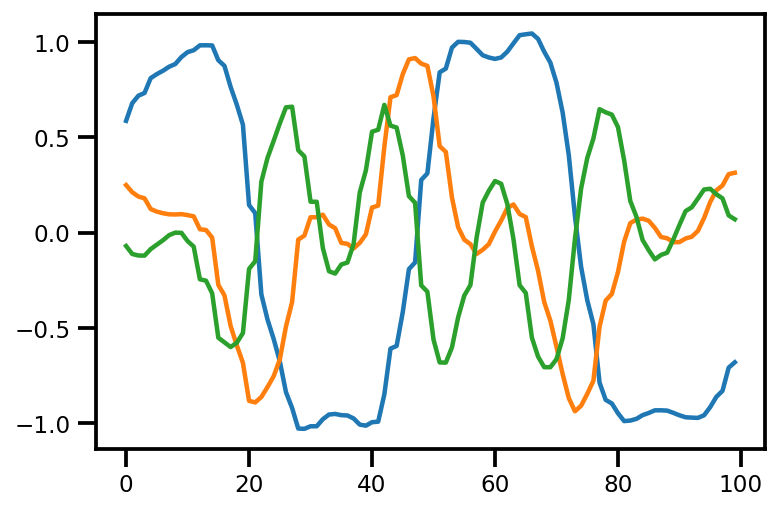

In [397]:
plt.plot(mu_)
plt.plot(dmu_.squeeze())
plt.plot(d2mu_.squeeze())

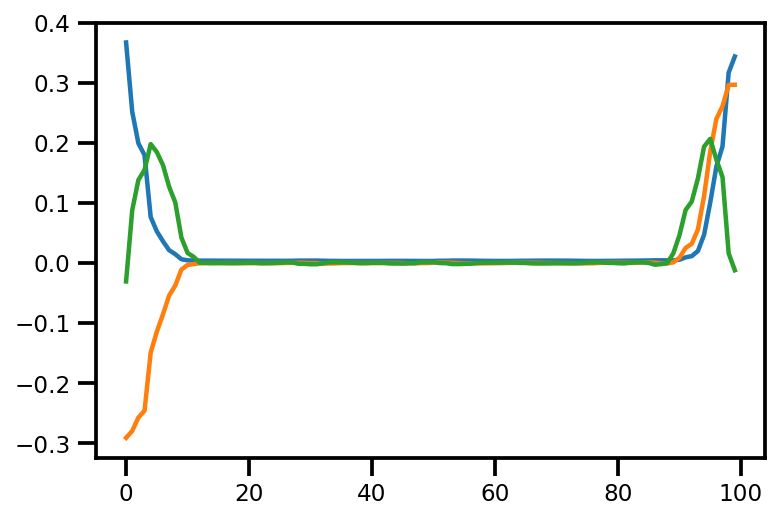

In [398]:
plt.plot(var_)
plt.plot(dvar_.squeeze())
plt.plot(d2var_.squeeze())

In [286]:
mu_o1 , cov_o1 = taylor_first_order(f, df, Xtest[0], Xcov[0])
mu_o2 , cov_o2 = taylor_second_order(f, df, df2, dvf2, Xtest[0], Xcov[0])

mu_o1.shape, cov_o1.shape, mu_o2.shape, cov_o2.shape

(1, 1)


((), (1,), (), (1,))

In [287]:
mu_o1 , cov_o1 = jax.vmap(taylor_first_order, in_axes=(None, None, 0, 0))(f, df, Xtest, Xcov)
mu_o2 , cov_o2 = jax.vmap(taylor_second_order, in_axes=(None, None, None, None, 0, 0))(f, df, df2, dvf2, Xtest, Xcov)

mu_o1.shape, cov_o1.shape, mu_o2.shape, cov_o2.shape

(1, 1)


((100,), (100, 1), (100,), (100, 1))

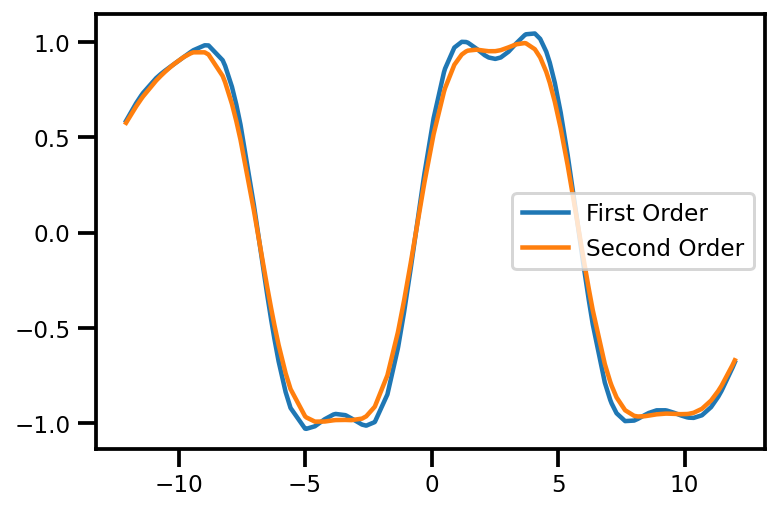

In [288]:
plt.plot(Xtest, mu_o1, label="First Order")
plt.plot(Xtest, mu_o2, label="Second Order")
plt.legend()

In [ ]:
lb, ub = confidence_intervals(mu_o1, var_o1, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

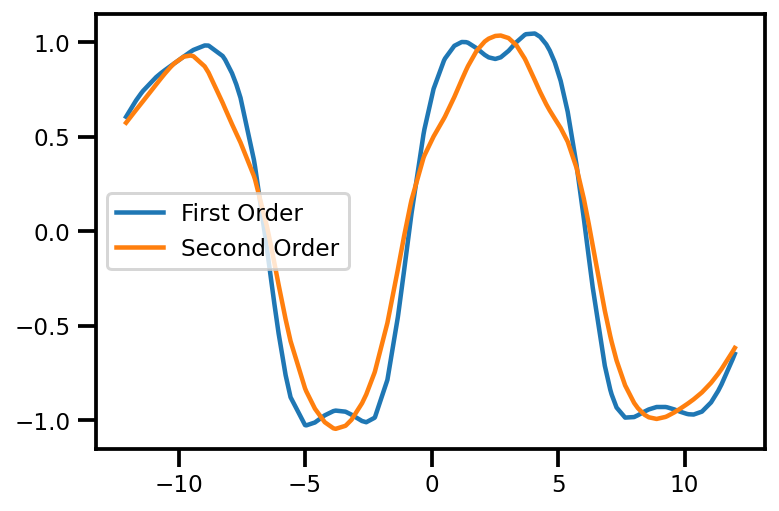

In [293]:
# plt.plot(Xtest, mu_o2, label="Exact")
plt.plot(Xtest, mu_o1 + cov_o1.squeeze(), label="First Order")
plt.plot(Xtest, mu_o2 + cov_o2.squeeze(), label="Second Order")
plt.legend()

In [229]:
f_vj = jax.jit(jax.vmap(jax.partial(predictive_mean, model)))
df_vj = jax.jit(jax.vmap(jax.grad(f)))
df2_vj = jax.jit(jax.vmap(jax.hessian(f)))

mu_ = f_vj(Xtest)
dmu_ = df_vj(Xtest)
d2mu_ = df2_vj(Xtest)
mu_.shape, dmu_.shape, d2mu_.shape

((100,), (100, 1), (100, 1, 1))

In [ ]:
mu, cov = taylor(f, df, )

In [111]:
mu_ = f(Xtest[0])
dmu_ = df(Xtest[0])
mu_.shape, dmu_.shape

((), (1,))

In [151]:
Xcov = np.tile(np.diag(np.array([0.1])), (Xtest.shape[0], 1, 1))
Xcov.shape

(100, 1, 1)

In [152]:
mu_o1, var_o1 = linearization(f, df, Xtest[0], Xcov[0])
mu_o1.shape, var_o1.shape

(1, 1) ()


((), (1,))

In [158]:
lin_f = jax.jit(jax.vmap(jax.partial(linearization, f, df), in_axes=(0, 0)))

In [159]:
mu_o1, cov_o1 = lin_f(Xtest, Xcov)
mu_o1.shape, cov_o1.shape



((100,), (100, 1))

In [128]:
np.diagonal(var_o1, axis1=1, axis2=2).shape

(100, 1)

In [134]:
cov = np.linspace(0, 5, 5+1) * np.eye(5+1)

In [143]:
cov_ = np.tile(cov, (3, 1, 1))
cov_

DeviceArray([[[0., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 0., 0.],
              [0., 0., 2., 0., 0., 0.],
              [0., 0., 0., 3., 0., 0.],
              [0., 0., 0., 0., 4., 0.],
              [0., 0., 0., 0., 0., 5.]],

             [[0., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 0., 0.],
              [0., 0., 2., 0., 0., 0.],
              [0., 0., 0., 3., 0., 0.],
              [0., 0., 0., 0., 4., 0.],
              [0., 0., 0., 0., 0., 5.]],

             [[0., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 0., 0.],
              [0., 0., 2., 0., 0., 0.],
              [0., 0., 0., 3., 0., 0.],
              [0., 0., 0., 0., 4., 0.],
              [0., 0., 0., 0., 0., 5.]]], dtype=float32)

In [144]:
cov_diag = np.diagonal(cov_, axis1=1, axis2=2)
cov_diag

DeviceArray([[0., 1., 2., 3., 4., 5.],
             [0., 1., 2., 3., 4., 5.],
             [0., 1., 2., 3., 4., 5.]], dtype=float32)

In [147]:
np.einsum("ijj->i", cov_)

DeviceArray([15., 15., 15.], dtype=float32)